# Introduction: Welcome to the Hands-On Lab!

Welcome! This hands-on lab session offers practical experience with PyTorch for building, training, and evaluating neural network models.

Following the concepts covered in the lecture (**Tensors, Autograd, Data, Models, Loss, Optimizers, Training**), you'll work with a sample dataset, load a pre-trained model, and fine-tune it for a classification task.

Don't worry if things seem complex at first – the goal is to get hands-on experience. Feel free to experiment with the code! Let's get started!

## Step 1. Data Handling

As discussed in the lecture, handling data efficiently is crucial. We'll use PyTorch's `Dataset` and `DataLoader` classes, along with `transforms`, to manage our dataset.

### 1.1 Dataset Overview

In this lab, we'll use a sample RTS (Retrogressive Thaw Slumps) dataset from Dr. Yili Yang's [research work](https://www.sciencedirect.com/science/article/pii/S0034425723000469).

While originally for semantic segmentation, we'll adapt it for classification.

**Goal:** Classify the number of RTS (1 to 10) present in each image.

**Dataset Structure:**
```
cyber2a/
│--- rts/
│    │--- images/  # Folder containing RGB images
│    │    │--- train_nitze_000.jpg
│    │    │--- ...
│--- data_split.json  # Specifies train/valtest splits
│--- rts_cls.json     # Maps image filenames to RTS counts (labels)
│--- rts_coco.json    # (Optional) Contains segmentation annotations
```

* `data_split.json`: A dictionary with two keys: `train` and `valtest`:
    - `train`: A list of image filenames for training.
    - `valtest`: A list of image filenames for validation and testing.
* `rts_cls.json`: A dictionary with image filenames as keys and the number of RTS in each image as values.

### 1.2 Download Dataset

First, let's download and unzip the dataset.

These commands use `wget` and `unzip`, common utilities in Colab/Linux environments.

In [1]:
#| label: Download-Dataset
# Download the dataset (using wget for compatibility)

print("Downloading and extracting dataset...")
!wget -O "cyber2a.zip" https://www.dropbox.com/scl/fi/1pz52tq3puomi0185ccyq/cyber2a.zip?rlkey=3dgf4gfrj9yk1k4p2znn9grso&st=bapbt1bq&dl=0
print("Unzipping dataset...")
!unzip -o cyber2a.zip -d . > /dev/null # Redirect verbose output
print("Dataset downloaded and extracted.")

--2025-05-06 14:19:21--  https://www.dropbox.com/scl/fi/1pz52tq3puomi0185ccyq/cyber2a.zip?rlkey=3dgf4gfrj9yk1k4p2znn9grso
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc5729ed030391453abdb4ec7943.dl.dropboxusercontent.com/cd/0/inline/CpIwMysGXSmUYnJ3yA9cnJexOMujzvbpYd4t08AlxfLTAPP7ArE73CDD6mFz63uiTIUx4S0tC9MaQlc738uD9PA_avJytNAk10f6H9YdYkDWLy9IZryD9VnkbdAP1HN2-1_1W2QwBRVa454svSIWDyKD/file# [following]
--2025-05-06 14:19:21--  https://uc5729ed030391453abdb4ec7943.dl.dropboxusercontent.com/cd/0/inline/CpIwMysGXSmUYnJ3yA9cnJexOMujzvbpYd4t08AlxfLTAPP7ArE73CDD6mFz63uiTIUx4S0tC9MaQlc738uD9PA_avJytNAk10f6H9YdYkDWLy9IZryD9VnkbdAP1HN2-1_1W2QwBRVa454svSIWDyKD/file
Resolving uc5729ed030391453abdb4ec7943.dl.dropboxusercontent.com (uc5729ed030391453abdb4ec7943.dl.dropboxusercontent.com)... 162.125.1.15, 2620:10

### 1.3 Visualize the Raw Data

Let's take a look at a sample image and its label directly from the files before we create our PyTorch Dataset. This helps understand the raw data format.

We will display the original image and the image with segmentation overlays (if aavilable) side-by-side for context, although our model will only perform classification.




Visualizing a raw data sample: original and with segmentation overlay...
COCO segmentation annotations loaded successfully for visualization.
Displaying Image: train_nitze_183.jpg, Original RTS Count: 2


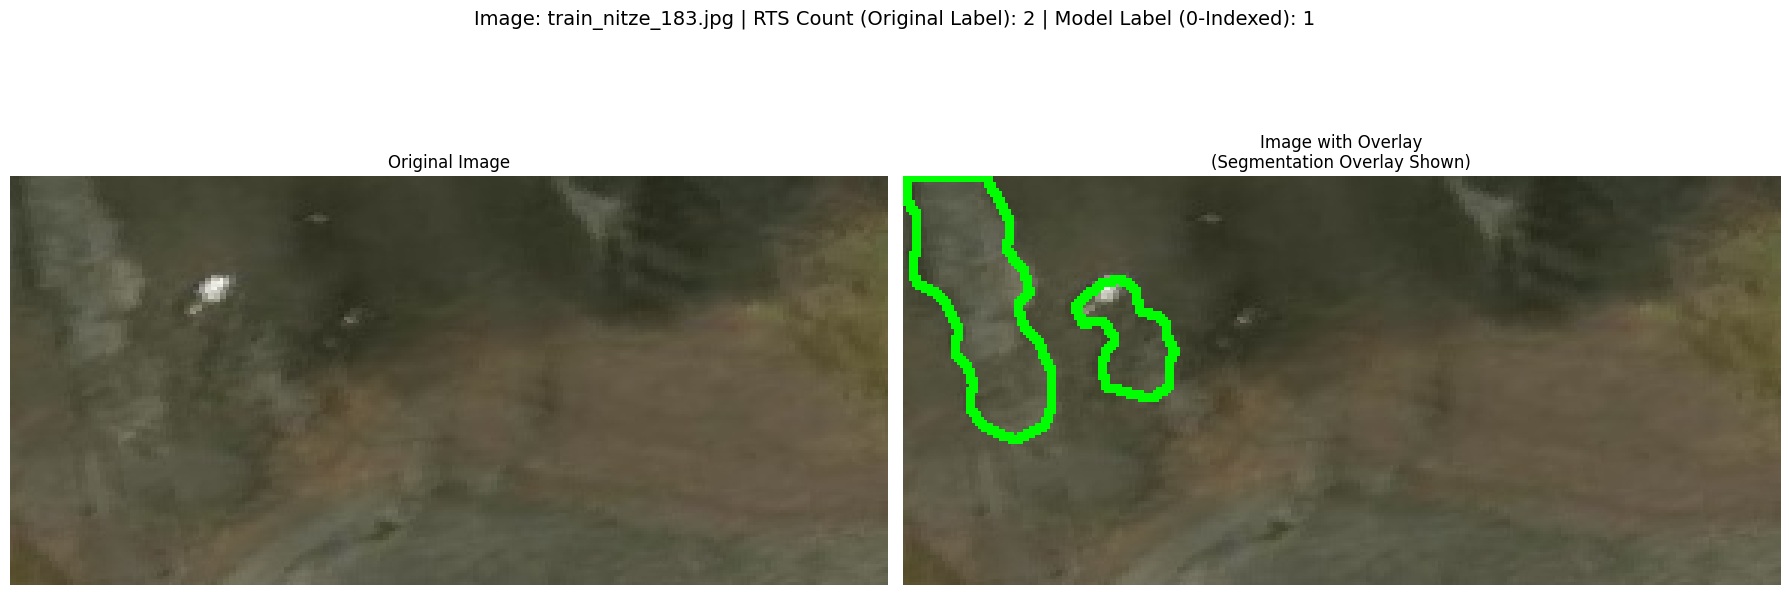

In [2]:
#| label: Visualize-Raw-Data
import os
import json
from PIL import Image
import matplotlib.pyplot as plt
import cv2  # OpenCV for drawing polygons
import numpy as np  # NumPy for image array manipulation

print("\nVisualizing a raw data sample: original and with segmentation overlay...")

# Define the directory where images are stored and path to COCO annotations
img_dir = "cyber2a/rts/images/"
coco_file_path = "cyber2a/rts_coco.json"

# Load the data split file to get lists of training and validation/test images
try:
    with open("cyber2a/data_split.json", 'r') as f:
        data_split = json.load(f)
except FileNotFoundError:
    print("Error: data_split.json not found. Make sure the dataset extracted correctly.")
    data_split = {} # Ensure data_split exists

# Retrieve the list of training images
img_list = data_split.get("train", []) # Use .get for safer dictionary access
if not img_list:
    print("Warning: No training images found in data_split.json.")

# Load the image labels (RTS counts)
img_labels = {} # Initialize
try:
    with open("cyber2a/rts_cls.json", 'r') as f:
        img_labels = json.load(f)
except FileNotFoundError:
    print("Error: rts_cls.json not found.")

# --- Load COCO annotations for drawing segmentation ---
coco_data = {} # To store loaded coco image_id_map and annotation_map
try:
    with open(coco_file_path, "r") as f:
        rts_coco_json = json.load(f)

    image_id_map = {img_info['file_name']: img_info['id'] for img_info in rts_coco_json.get('images', [])}
    coco_data['image_id_map'] = image_id_map

    annotation_map = {}
    for ann in rts_coco_json.get('annotations', []):
        img_id = ann['image_id']
        if img_id not in annotation_map:
            annotation_map[img_id] = []
        if 'segmentation' in ann and ann['segmentation']:
            annotation_map[img_id].append(ann['segmentation'])
    coco_data['annotation_map'] = annotation_map
    if image_id_map and annotation_map:
        print("COCO segmentation annotations loaded successfully for visualization.")
    else:
        print("COCO segmentation annotations loaded, but parts might be empty (e.g. no images or no annotations).")

except FileNotFoundError:
    print(f"Warning: Segmentation annotation file '{coco_file_path}' not found. Cannot display segmentation overlays.")
except json.JSONDecodeError:
    print(f"Warning: Error decoding JSON from '{coco_file_path}'. Cannot display segmentation overlays.")
except Exception as e:
    print(f"Warning: An unexpected error occurred while loading COCO annotations from '{coco_file_path}': {e}")
# --- End COCO annotation loading ---

if img_list:
    img_name = img_list[0]
    img_label_count = img_labels.get(img_name, "N/A")

    print(f"Displaying Image: {img_name}, Original RTS Count: {img_label_count}")
    img_path = os.path.join(img_dir, img_name)

    try:
        pil_image = Image.open(img_path).convert("RGB")

        label_index = "N/A"
        if img_label_count != "N/A":
            try:
                label_index = int(img_label_count) - 1
            except ValueError:
                print(f"Warning: Could not convert label_count '{img_label_count}' to int for {img_name}")
                label_index = "Error"

        fig, axs = plt.subplots(1, 2, figsize=(18, 7)) # 1 row, 2 columns

        # --- Display original image (left subplot) ---
        axs[0].imshow(pil_image)
        axs[0].axis('off')
        axs[0].set_title("Original Image")

        # --- Prepare image for annotations (right subplot) ---
        # Convert PIL image to NumPy array. np.array() typically creates a copy.
        image_for_overlay = np.array(pil_image)

        annotations_drawn_successfully = False
        annotation_status_message = "(Segmentation Annotations Not Loaded)"

        if coco_data.get('image_id_map') and coco_data.get('annotation_map'):
            annotation_status_message = "(No Segmentation Overlay for this Image)" # Default if COCO loaded but no annot.
            image_id_map = coco_data['image_id_map']
            annotation_map = coco_data['annotation_map']

            if img_name in image_id_map:
                current_image_id = image_id_map[img_name]
                if current_image_id in annotation_map:
                    segmentations_for_image = annotation_map[current_image_id]
                    if segmentations_for_image:
                        for ann_segmentation_list in segmentations_for_image:
                            for polygon_coords in ann_segmentation_list:
                                try:
                                    polygon = np.array(polygon_coords, dtype=np.int32).reshape((-1, 1, 2))
                                    # Draw on the NumPy array copy
                                    cv2.polylines(image_for_overlay, [polygon], isClosed=True, color=(0, 255, 0), thickness=2)
                                    annotations_drawn_successfully = True
                                except ValueError as ve:
                                    print(f"Warning: Malformed polygon coordinates for {img_name}. Details: {ve}")
                                except Exception as e:
                                    print(f"Warning: Could not draw a polygon for {img_name}. Details: {e}")
                        if annotations_drawn_successfully:
                             annotation_status_message = "(Segmentation Overlay Shown)"
                        else: # Annotations existed but none could be drawn
                            annotation_status_message = "(Error Drawing Segmentation Overlay)"
                    else: # No segmentations listed for this image_id
                        # print(f"No segmentation data found for image ID {current_image_id} ({img_name}) in annotation_map.")
                        annotation_status_message = "(No Segmentation Data for this Image)"
                else: # image_id not in annotation_map
                    # print(f"Image ID {current_image_id} ({img_name}) not found in COCO annotation_map.")
                    annotation_status_message = "(Image ID Not in Annotation Map)"
            else: # img_name not in image_id_map
                 # print(f"Image name '{img_name}' not found in COCO image_id_map.")
                 annotation_status_message = "(Image Not in COCO Map)"
        # else: coco_data is empty (file not found or error during load), initial status_message applies.

        axs[1].imshow(image_for_overlay) # Display the image with annotations
        axs[1].axis('off')
        axs[1].set_title(f"Image with Overlay\n{annotation_status_message}")

        fig.suptitle(f"Image: {img_name} | RTS Count (Original Label): {img_label_count} | Model Label (0-Indexed): {label_index}", fontsize=14)
        plt.tight_layout(rect=[0, 0.03, 1, 0.92]) # Adjust rect for suptitle
        plt.show()

    except FileNotFoundError:
        print(f"Error: Image file {img_path} not found.")
        # If image not found, try to show empty plots or a message
        fig, axs = plt.subplots(1, 2, figsize=(18, 7))
        axs[0].text(0.5, 0.5, 'Image not found', horizontalalignment='center', verticalalignment='center', transform=axs[0].transAxes)
        axs[1].text(0.5, 0.5, 'Image not found', horizontalalignment='center', verticalalignment='center', transform=axs[1].transAxes)
        axs[0].axis('off')
        axs[1].axis('off')
        fig.suptitle(f"Image: {img_name} - FILE NOT FOUND", fontsize=14, color='red')
        plt.show()
    except Exception as e:
        print(f"An error occurred displaying the image {img_name}: {e}")
else:
    print("Cannot display sample: Training image list is empty or could not be loaded.")
    # Optionally, display a placeholder if no image can be shown
    fig, axs = plt.subplots(1, 2, figsize=(18, 7))
    axs[0].text(0.5, 0.5, 'No image selected', horizontalalignment='center', verticalalignment='center', transform=axs[0].transAxes)
    axs[1].text(0.5, 0.5, 'No image selected', horizontalalignment='center', verticalalignment='center', transform=axs[1].transAxes)
    axs[0].axis('off')
    axs[1].axis('off')
    fig.suptitle("No image available from training list", fontsize=14)
    plt.show()

### 1.4 Build a Custom PyTorch Dataset

As covered in the lecture, `torch.utils.data.Dataset` is the base class for representing datasets in PyTorch. We need to implement `__init__`, `__len__`, and `__getitem__`.

* `__init__`: Initialize the dataset.
* `__len__`: Return the total number of data samples in the dataset.
* `__getitem__`: Load a data sample and its corresponding label based on the index.

In [3]:
import torch # Import torch here if not already imported
from torch.utils.data import Dataset

class RTSDataset(Dataset):
    """Custom Dataset for RTS classification."""
    def __init__(self, split, transform=None):
        """
        Args:
            split (str): One of 'train' or 'valtest' to specify the dataset split.
            transform (callable, optional): Optional transform to be applied on a sample.
                                           As discussed in the lecture, transforms
                                           preprocess or augment the data.
        """
        self.img_dir = "cyber2a/rts/images/"
        self.transform = transform

        # Load image filenames based on the split
        try:
            with open("cyber2a/data_split.json") as f:
                data_split = json.load(f)
            if split == 'train':
                self.img_list = data_split['train']
            elif split == 'valtest':
                self.img_list = data_split['valtest']
            else:
                raise ValueError("Invalid split: choose either 'train' or 'valtest'")
        except FileNotFoundError:
            print("Error: data_split.json not found.")
            self.img_list = [] # Initialize as empty list on error
        except KeyError:
            print(f"Error: Split '{split}' not found in data_split.json.")
            self.img_list = []

        # Load image labels (RTS counts)
        try:
            with open("cyber2a/rts_cls.json") as f:
                self.img_labels = json.load(f)
        except FileNotFoundError:
            print("Error: rts_cls.json not found.")
            self.img_labels = {} # Initialize as empty dict on error

        print(f"Initialized RTSDataset for '{split}' split with {len(self.img_list)} images.")

    def __len__(self):
        """Returns the total number of samples in the dataset."""
        return len(self.img_list)

    def __getitem__(self, idx):
        """
        Retrieves the image and its label at the given index `idx`.
        This is where data loading and transformation happen for a single sample.

        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            tuple: (image, label) where image is the transformed image tensor
                   and label is the 0-indexed integer label.
        """
        if idx >= len(self.img_list):
            raise IndexError("Index out of bounds")

        img_name = self.img_list[idx]
        img_path = os.path.join(self.img_dir, img_name)

        try:
            # Load image using PIL
            image = Image.open(img_path).convert('RGB')
        except FileNotFoundError:
            print(f"Warning: Image file not found at {img_path}. Returning None.")
            # Or handle differently, e.g., return a placeholder or skip
            return None, None
        except Exception as e:
            print(f"Warning: Error loading image {img_path}: {e}. Returning None.")
            return None, None

        # Get the label (RTS count) and convert to 0-indexed integer
        label_count = self.img_labels.get(img_name)
        if label_count is None:
            print(f"Warning: Label not found for image {img_name}. Assigning label -1.")
            label = -1 # Or handle differently
        else:
            label = int(label_count) - 1 # 0-indexing

        # Apply transformations if they exist
        if self.transform:
            image = self.transform(image)

        # Convert label to a tensor (optional but good practice)
        # Using LongTensor as CrossEntropyLoss expects integer labels
        label = torch.tensor(label, dtype=torch.long)

        return image, label

### 1.5 Test the Custom Dataset

Let's create an instance of our `RTSDataset` and check if `__getitem__` works correctly by fetching and displaying a sample.

Initialized RTSDataset for 'train' split with 756 images.

Displaying raw samples from dataset:


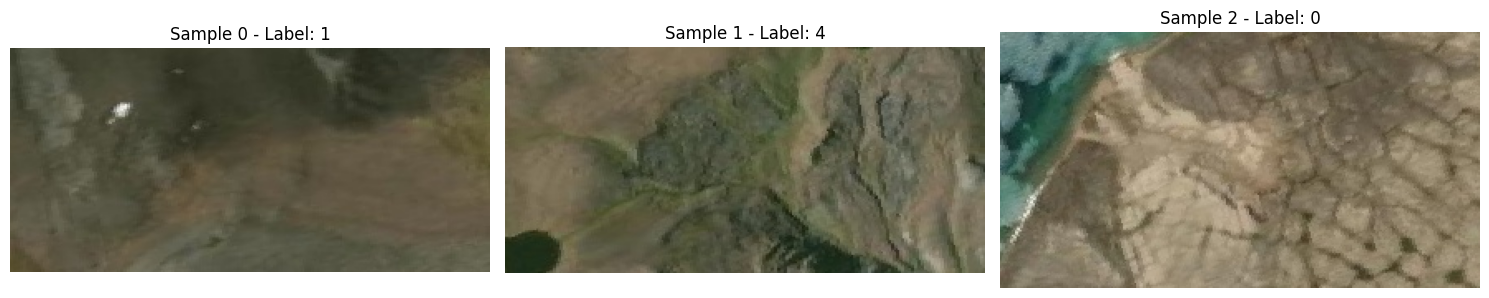

In [4]:
#| label: Test-Custom-Dataset
# Helper function to display sample images (can handle tensors or PIL Images)
def display_sample_images(dataset, num_images=3):
    """Displays sample images from a PyTorch Dataset."""
    fig, axs = plt.subplots(1, num_images, figsize=(15, 5))
    if num_images == 1:
        axs = [axs] # Make it iterable if only one image

    for i in range(num_images):
        if i >= len(dataset):
            print(f"Requested image index {i} out of bounds for dataset size {len(dataset)}.")
            continue

        img, label = dataset[i]

        if img is None: # Handle cases where __getitem__ returned None
             print(f"Skipping display for index {i}, image data is None.")
             if num_images == 1: axs[i].set_title("Image Load Error")
             continue

        # If the dataset applies transforms (including ToTensor),
        # the image will be a Tensor. We need to convert it back for display.
        if isinstance(img, torch.Tensor):
            # Undo normalization and convert C x H x W to H x W x C
            mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
            std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
            img = img * std + mean # Unnormalize
            img = img.permute(1, 2, 0) # C x H x W -> H x W x C
            img = img.clamp(0, 1) # Ensure values are in [0, 1] range
            img = img.numpy() # Convert to NumPy array

        axs[i].imshow(img)
        axs[i].set_title(f"Sample {i} - Label: {label.item() if isinstance(label, torch.Tensor) else label}") # Use .item() to get scalar from tensor
        axs[i].axis("off")

    plt.tight_layout()
    plt.show()

# Create the training dataset *without* transforms first to see raw images
try:
    raw_train_dataset = RTSDataset("train", transform=None)
    if len(raw_train_dataset) > 0:
         print("\nDisplaying raw samples from dataset:")
         display_sample_images(raw_train_dataset, num_images=3)
    else:
        print("Raw train dataset is empty, cannot display samples.")
except Exception as e:
    print(f"Error creating/displaying raw dataset: {e}")

### 1.6 Define Data Transforms and DataLoaders

Now, let's define the transformations we want to apply to our images.

As discussed in the lecture, these are crucial for preparing data for the model.

We'll then create `DataLoaders` to handle batching and shuffling.



Defining transforms and dataloaders...
Initialized RTSDataset for 'train' split with 756 images.
Initialized RTSDataset for 'valtest' split with 138 images.

Displaying transformed samples from training dataset:


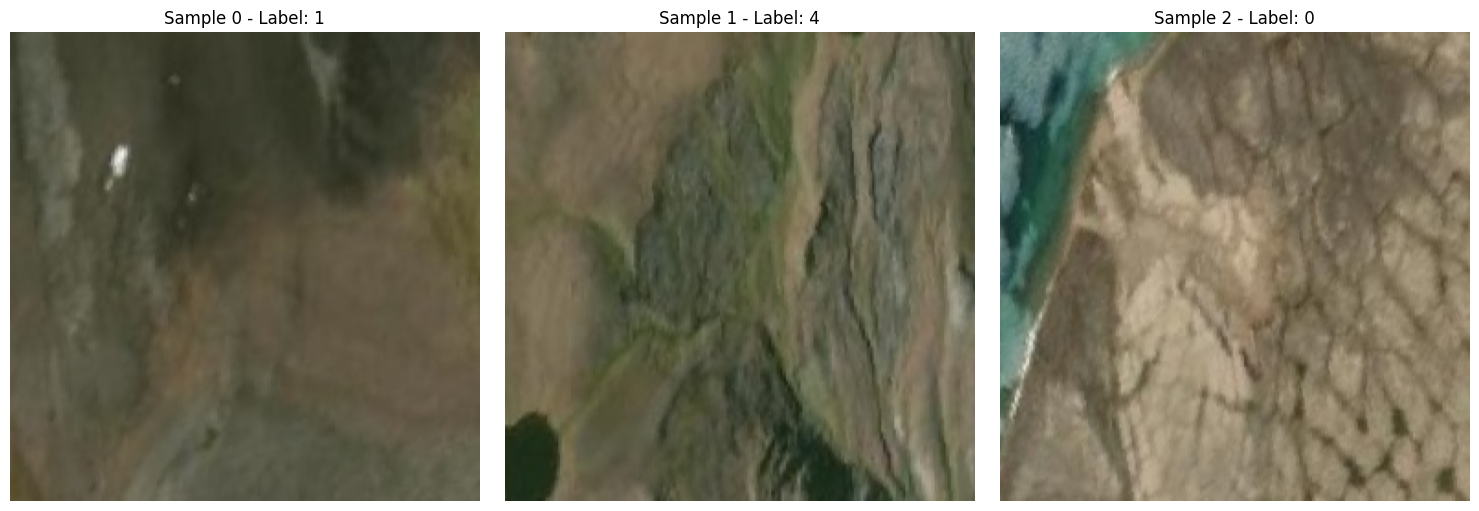


DataLoaders created.
Sample batch - Images shape: torch.Size([4, 3, 256, 256]), Labels shape: torch.Size([4])


In [5]:
#| label: Define-Data-Transforms-and-DataLoaders
import torchvision.transforms as T
from torch.utils.data import DataLoader

print("\nDefining transforms and dataloaders...")

# Define the transformations:
# 1. Resize: Ensure all images have the same size, required by many models.
#            ResNet-18 (and many ImageNet models) often expect 224x224 or 256x256.
# 2. ToTensor: Converts PIL Image (H x W x C) [0, 255] to PyTorch Tensor (C x H x W) [0.0, 1.0].
#              This also automatically moves channel dimension first. Crucial step!
# 3. Normalize: Standardizes pixel values using mean and standard deviation.
#               Using ImageNet stats is common practice when using pre-trained models,
#               as it matches the data the model was originally trained on.
#               Helps with model convergence.
transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# --- Practice Idea ---
# Try adding data augmentation transforms for the training set!
# Uncomment and modify the transform_train below. Remember to only use
# augmentation for the training set, not validation/testing.
# transform_train = T.Compose([
#     T.Resize((256, 256)),
#     T.RandomHorizontalFlip(p=0.5), # Example augmentation
#     T.RandomRotation(10),         # Example augmentation
#     T.ToTensor(),
#     T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])
# train_dataset = RTSDataset("train", transform=transform_train) # Use augmented transform
# ---------------------

# Create the training and validation datasets *with* transforms
try:
    train_dataset = RTSDataset("train", transform=transform)
    val_dataset = RTSDataset("valtest", transform=transform)

    # Display transformed samples to check
    if len(train_dataset) > 0:
        print("\nDisplaying transformed samples from training dataset:")
        display_sample_images(train_dataset, num_images=3)
    else:
        print("Train dataset is empty, cannot display transformed samples.")

    # Create DataLoaders (Lecture Topic: DataLoader)
    # - `dataset`: The Dataset object to load from.
    # - `batch_size`: How many samples per batch. Affects memory and training dynamics.
    # - `shuffle`: Whether to shuffle data every epoch (True for training is crucial!).
    # - `num_workers`: Number of subprocesses for data loading. Increases speed but uses more memory. Start with 0 or 2.
    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2) # No shuffle for validation

    print("\nDataLoaders created.")
    # Optional: Iterate over one batch to see the output shape
    try:
        dataiter = iter(train_loader)
        images, labels = next(dataiter)
        print(f"Sample batch - Images shape: {images.shape}, Labels shape: {labels.shape}")
    except StopIteration:
        print("Could not fetch a batch from train_loader (it might be empty).")
    except Exception as e:
         print(f"Error iterating over DataLoader: {e}")


except Exception as e:
    print(f"An error occurred during Dataset/DataLoader creation: {e}")

## Step 2. Model Definition

As covered in the lecture, we often don't need to train models from scratch.

We can use **Transfer Learning** by loading a **Pre-trained Model** (like ResNet-18 trained on ImageNet) and adapting its final layer for our specific task.

We'll use `torchvision.models` for this. Remember that the core building block for models in PyTorch is `nn.Module`.

In [6]:
#| label: Model-Definition
from torchvision import models
import torch.nn as nn # Import the neural network module

print("\nLoading pre-trained ResNet-18 model...")

# Load the pre-trained ResNet-18 model.
# `weights=ResNet18_Weights.DEFAULT` automatically fetches weights pre-trained on ImageNet.
# This leverages features learned on a large dataset.
model = models.resnet18(weights=models.resnet.ResNet18_Weights.DEFAULT)

# **Adapting the Model Head (Transfer Learning)**
# The pre-trained ResNet-18 has a final fully connected layer (`fc`) designed
# for ImageNet's 1000 classes. We need to replace it with a new layer that
# outputs scores for our 10 classes (RTS counts 1-10, which are labels 0-9).

# 1. Get the number of input features to the original fully connected layer.
num_ftrs = model.fc.in_features
print(f"Original ResNet-18 fc layer input features: {num_ftrs}")

# 2. Create a new fully connected layer (`nn.Linear`) with the correct number
#    of input features (`num_ftrs`) and the desired number of output classes (10).
#    The parameters of this new layer will be randomly initialized and trained.
model.fc = nn.Linear(num_ftrs, 10)
print("Replaced final fc layer for 10 output classes.")

# Print the model architecture to observe the change in the final `fc` layer.
# print("\nModified Model Architecture:")
# print(model)

# --- Practice Idea ---
# Try loading a different pre-trained model, like ResNet-34 or MobileNetV2.
# You'll need to find the name of its final classification layer (it might not be 'fc')
# and replace it similarly.
# Example:
# model_mobilenet = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
# print(model_mobilenet) # Inspect the layers to find the classifier name
# num_ftrs_mobilenet = model_mobilenet.classifier[1].in_features # Example for MobileNetV2
# model_mobilenet.classifier[1] = nn.Linear(num_ftrs_mobilenet, 10)
# model = model_mobilenet # Use this model instead
# ---------------------


Loading pre-trained ResNet-18 model...
Original ResNet-18 fc layer input features: 512
Replaced final fc layer for 10 output classes.


## Step 3. Loss Function

The Loss Function measures how far the model's predictions are from the true labels. For multi-class classification (like our 10 RTS classes), `CrossEntropyLoss` is the standard choice (as mentioned in the lecture).

**Important:** `CrossEntropyLoss` expects raw scores (logits) from the model (it applies Softmax internally) and 0-indexed integer labels.

In [7]:
#| label: Loss-Function
print("\nDefining Loss Function...")
# Define the loss function
criterion = nn.CrossEntropyLoss()
print("Using CrossEntropyLoss.")


Defining Loss Function...
Using CrossEntropyLoss.


## Step 4. Optimization Algorithm

The Optimizer updates the model's weights based on the gradients calculated during backpropagation to minimize the loss. We'll use Stochastic Gradient Descent (SGD) with momentum, a common and effective optimizer (see lecture).

In [8]:
#| label: Optimization-Algorithm
import torch.optim as optim

print("\nDefining Optimizer...")
# Define the optimizer
# - `model.parameters()`: Tells the optimizer which parameters to update.
# - `lr`: Learning Rate - controls the step size of updates. Needs tuning.
# - `momentum`: Helps accelerate SGD in the relevant direction.
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
print("Using SGD optimizer with lr=0.001 and momentum=0.9.")

# --- Practice Idea ---
# Try using the Adam optimizer instead. It often requires less learning rate tuning.
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# print("Using Adam optimizer with lr=0.001.")
# ---------------------


Defining Optimizer...
Using SGD optimizer with lr=0.001 and momentum=0.9.


## Step 5. Training and Evaluation Loop

This is where we put everything together: iterating through the data,
feeding it to the model, calculating loss, backpropagating, and updating weights.

We'll also evaluate on the validation set after each epoch.

In [9]:
#| label: Training-and-Evaluation-Loop
import time
from tqdm import tqdm # tqdm provides progress bars for loops

print("\nDefining Training and Evaluation Functions...")

def train_eval_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=5):
    """
    Trains and evaluates the model.

    Args:
        model (nn.Module): The model to train.
        criterion (nn.Module): The loss function.
        optimizer (optim.Optimizer): The optimizer.
        train_loader (DataLoader): DataLoader for the training data.
        val_loader (DataLoader): DataLoader for the validation data.
        num_epochs (int): Number of epochs to train.

    Returns:
        nn.Module: The trained model.
    """
    # Check for GPU availability and set device (Lecture Topic: GPU Usage)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    model.to(device) # Move model to the chosen device

    best_val_acc = 0.0 # Keep track of best validation accuracy

    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        print(f"\n--- Epoch {epoch+1}/{num_epochs} ---")

        # ---------------------
        # Training Phase
        # ---------------------
        model.train() # **Crucial:** Set model to training mode (enables dropout, batchnorm updates etc.)
        running_loss = 0.0
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1} Training")

        for inputs, labels in train_pbar:
            # Move data to the correct device
            inputs, labels = inputs.to(device), labels.to(device)

            # **Crucial:** Zero the parameter gradients (Lecture Topic: Optimizers)
            # Otherwise gradients accumulate from previous batches.
            optimizer.zero_grad()

            # Forward pass: Get model outputs (logits)
            outputs = model(inputs)

            # Compute the loss
            loss = criterion(outputs, labels)

            # Backward pass: Compute gradients of the loss w.r.t. parameters
            loss.backward()

            # Update model parameters based on gradients
            optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0) # Weighted by batch size
            train_pbar.set_postfix({'loss': loss.item()}) # Show current batch loss in progress bar

        epoch_loss = running_loss / len(train_loader.dataset) # Average loss over dataset
        print(f"Training Loss: {epoch_loss:.4f}")

        # ---------------------
        # Validation Phase
        # ---------------------
        model.eval()  # **Crucial:** Set model to evaluation mode (disables dropout, uses running BN stats)
        correct = 0
        total = 0
        val_loss = 0.0
        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1} Validation")

        # **Crucial:** Disable gradient calculations for efficiency (Lecture Topic: Autograd / Evaluation)
        with torch.no_grad():
            for inputs, labels in val_pbar:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)

                # Calculate validation loss
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                # Calculate accuracy
                _, predicted = torch.max(outputs.data, 1) # Get the index of the max logit
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                val_pbar.set_postfix({'acc': (100 * correct / total)})

        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_acc = 100 * correct / total
        print(f"Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_acc:.2f}%")

        # Simple check for saving the best model (optional)
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            # torch.save(model.state_dict(), 'best_model.pth') # Example saving
            # print("Saved new best model.")

        epoch_duration = time.time() - epoch_start_time
        print(f"Epoch Duration: {epoch_duration:.2f} seconds")

        # --- Practice Idea ---
        # Add code here to implement early stopping. For example, if the validation
        # accuracy doesn't improve for, say, 2 epochs, stop the training loop.
        # You'll need to store the validation accuracy from the previous epoch.
        # ---------------------

    print("\nFinished Training.")
    return model



Defining Training and Evaluation Functions...


### 5.1 Train the Model

Let's start the training process for a few epochs.

In [10]:
#| label: Train-the-Model
print("\nStarting model training...")
# Ensure the model is on the correct device before passing to train function
# (train_eval_model also moves it, but good practice to do it here too)
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model.to(device)

# Train the model
try:
    model = train_eval_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=5)
except Exception as e:
     print(f"An error occurred during training: {e}")


Starting model training...
Using device: cuda:0

--- Epoch 1/5 ---


Epoch 1 Training: 100%|██████████| 189/189 [00:05<00:00, 35.20it/s, loss=2.45]


Training Loss: 1.7698


Epoch 1 Validation: 100%|██████████| 35/35 [00:00<00:00, 36.59it/s, acc=37.7]


Validation Loss: 1.7400, Validation Accuracy: 37.68%
Epoch Duration: 6.34 seconds

--- Epoch 2/5 ---


Epoch 2 Training: 100%|██████████| 189/189 [00:05<00:00, 33.47it/s, loss=1.54]


Training Loss: 1.4983


Epoch 2 Validation: 100%|██████████| 35/35 [00:00<00:00, 58.25it/s, acc=38.4]


Validation Loss: 1.7676, Validation Accuracy: 38.41%
Epoch Duration: 6.26 seconds

--- Epoch 3/5 ---


Epoch 3 Training: 100%|██████████| 189/189 [00:04<00:00, 37.89it/s, loss=1.11]


Training Loss: 1.1677


Epoch 3 Validation: 100%|██████████| 35/35 [00:00<00:00, 55.74it/s, acc=39.9]


Validation Loss: 2.4771, Validation Accuracy: 39.86%
Epoch Duration: 5.63 seconds

--- Epoch 4/5 ---


Epoch 4 Training: 100%|██████████| 189/189 [00:05<00:00, 32.04it/s, loss=1.66]


Training Loss: 0.9606


Epoch 4 Validation: 100%|██████████| 35/35 [00:00<00:00, 57.02it/s, acc=33.3]


Validation Loss: 2.8200, Validation Accuracy: 33.33%
Epoch Duration: 6.52 seconds

--- Epoch 5/5 ---


Epoch 5 Training: 100%|██████████| 189/189 [00:05<00:00, 36.94it/s, loss=0.863]


Training Loss: 0.8626


Epoch 5 Validation: 100%|██████████| 35/35 [00:00<00:00, 55.70it/s, acc=36.2]

Validation Loss: 2.3195, Validation Accuracy: 36.23%
Epoch Duration: 5.75 seconds

Finished Training.


## Step 6. Inference (Making Predictions)

After training, we want to use the model to predict the class (RTS count)
for new, unseen images. This is the inference step. Remember to use
`model.eval()` and `torch.no_grad()`.


In [11]:
#| label: Inference
print("\nDefining prediction function...")

def predict_image(model, image_path, transform):
    """
    Predicts the class label for a single image.

    Args:
        model (nn.Module): The trained model.
        image_path (str): Path to the image file.
        transform (callable): The transformations to apply to the image.

    Returns:
        int: The predicted 0-indexed class label. Returns -1 on error.
    """
    try:
        image = Image.open(image_path).convert("RGB")
        # Apply the same transformations used during training/validation
        image_tensor = transform(image).unsqueeze(0) # Add batch dimension

        # Ensure model and data are on the same device
        device = next(model.parameters()).device
        image_tensor = image_tensor.to(device)

        model.eval() # Set model to evaluation mode
        with torch.no_grad(): # Disable gradients
            outputs = model(image_tensor)
            _, predicted = torch.max(outputs, 1)
            predicted_label = predicted.item() # Get the scalar value
            return predicted_label

    except FileNotFoundError:
        print(f"Error: Image not found at {image_path}")
        return -1
    except Exception as e:
        print(f"Error during prediction for {image_path}: {e}")
        return -1

# Example: Predict a specific image from the validation set
img_name_to_predict = "valtest_yg_070.jpg" # Example image
img_dir = "./cyber2a/rts/images"
img_path_to_predict = os.path.join(img_dir, img_name_to_predict)

print(f"\nPredicting class for image: {img_name_to_predict}")
predicted_class = predict_image(model, img_path_to_predict, transform)

if predicted_class != -1:
    # Add 1 back to get the RTS count (since labels are 0-indexed)
    predicted_rts_count = predicted_class + 1
    print(f"Predicted Class Index: {predicted_class}")
    print(f"Predicted RTS Count: {predicted_rts_count}")

    # --- Practice Idea ---
    # Choose a *different* image name from the `val_dataset.img_list`
    # and predict its class using the `predict_image` function.
    # Example:
    # if len(val_dataset) > 1:
    #     img_name_practice = val_dataset.img_list[1] # Get the second image name
    #     img_path_practice = os.path.join(img_dir, img_name_practice)
    #     predicted_class_practice = predict_image(model, img_path_practice, transform)
    #     print(f"\nPractice Prediction for {img_name_practice}: {predicted_class_practice}")
    # ---------------------


Defining prediction function...

Predicting class for image: valtest_yg_070.jpg
Predicted Class Index: 1
Predicted RTS Count: 2


## Step 7. Visualization

Let's visualize the image we just predicted on, showing the predicted RTS count.

We'll also overlay the original segmentation annotations (if available) for context, although our model only performed classification.




Visualizing prediction...


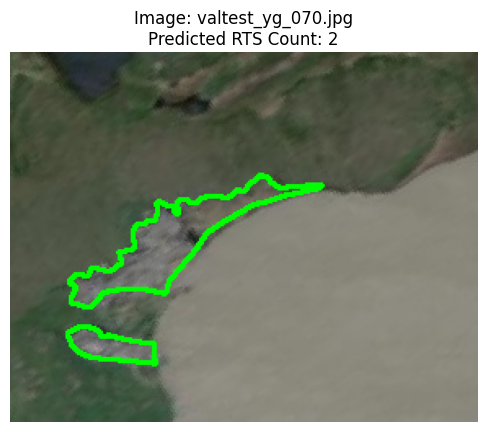

In [12]:
#| label: Visualization
import matplotlib.pyplot as plt
import cv2 # OpenCV for image handling
import numpy as np

print("\nVisualizing prediction...")

def display_image_with_annotations(image_name, image_folder, predicted_class):
    """
    Displays an image with its original annotations (if available) and the
    predicted class label from our model.

    Args:
        image_name (str): The name of the image file.
        image_folder (str): The folder where the image is stored.
        predicted_class (int): The 0-indexed predicted class label.
    """
    # Load the COCO annotations (optional, for context only)
    coco_annotations = {}
    try:
        with open("cyber2a/rts_coco.json", "r") as f:
            rts_coco = json.load(f)

        # Create a mapping from image filename to image ID and annotations
        image_id_map = {img['file_name']: img['id'] for img in rts_coco.get('images', [])}
        annotation_map = {}
        for ann in rts_coco.get('annotations', []):
            img_id = ann['image_id']
            if img_id not in annotation_map:
                annotation_map[img_id] = []
            annotation_map[img_id].append(ann['segmentation'])

        image_id = image_id_map.get(image_name)
        annotations = annotation_map.get(image_id, []) if image_id else []
        coco_annotations['annotations'] = annotations # Store for drawing

    except FileNotFoundError:
        print("Warning: rts_coco.json not found. Cannot display annotations.")
        coco_annotations['annotations'] = []
    except Exception as e:
        print(f"Warning: Error loading COCO annotations: {e}")
        coco_annotations['annotations'] = []


    # Read the image using OpenCV
    img_path = os.path.join(image_folder, image_name)
    try:
        cv2_image = cv2.imread(img_path)
        if cv2_image is None:
            raise FileNotFoundError
        # Convert from BGR (OpenCV default) to RGB (matplotlib default)
        cv2_image = cv2.cvtColor(cv2_image, cv2.COLOR_BGR2RGB)
    except FileNotFoundError:
        print(f"Error: Image file not found at {img_path}")
        return
    except Exception as e:
        print(f"Error reading image {img_path} with OpenCV: {e}")
        return

    # Overlay the polygons (optional visualization)
    for annotation_list in coco_annotations.get('annotations', []):
        for polygon_coords in annotation_list:
            try:
                # Reshape polygon coordinates for cv2.polylines
                polygon = np.array(polygon_coords, dtype=np.int32).reshape((-1, 1, 2))
                cv2.polylines(cv2_image, [polygon], isClosed=True, color=(0, 255, 0), thickness=2)
            except Exception as e:
                print(f"Warning: Could not draw polygon {polygon_coords}: {e}")


    # Display the image with the predicted label
    fig, ax = plt.subplots()
    ax.imshow(cv2_image)
    # Add 1 back to predicted_class to show the RTS count
    ax.set_title(f'Image: {image_name}\nPredicted RTS Count: {predicted_class + 1}')
    ax.axis('off')
    plt.show()

# Visualize the prediction for the example image
if predicted_class != -1:
    display_image_with_annotations(img_name_to_predict, img_dir, predicted_class)
else:
    print("Cannot visualize prediction due to previous error.")

## Conclusion & Next Steps

Congratulations! You've successfully:
1. Loaded and prepared data using `Dataset`, `Transforms`, and `DataLoader`.
2. Loaded a pre-trained `nn.Module` (ResNet-18) and adapted it using transfer learning.
3. Defined a loss function (`CrossEntropyLoss`) and optimizer (`SGD`).
4. Implemented and run a basic training and validation loop.
5. Performed inference on a single image.
6. Visualized the prediction.

This covers the fundamental workflow of a PyTorch application!

**Where to go from here?**
* **Experiment:** Try the "Practice Ideas" suggested in the comments above.
* **Tune Hyperparameters:** Adjust the learning rate, batch size, or number of epochs.
* **Data Augmentation:** Implement more complex transforms for the training data.
* **Different Models:** Try other pre-trained architectures from `torchvision.models`.
* **Metrics:** Use libraries like `torchmetrics` or `scikit-learn` for more detailed evaluation (precision, recall, F1-score).
* **Learning Rate Scheduling:** Implement a learning rate scheduler (`torch.optim.lr_scheduler`).
* **Saving/Loading:** Add code to save your trained model's `state_dict` and load it later (as shown in the lecture).

Keep practicing and exploring!